In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from cvae_featurization import *
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from cvae import TempTimeGenerator
from hyperopt import fmin, tpe, hp, STATUS_OK
import re

Using TensorFlow backend.


In [2]:
imputation_strategy="mp_fraction"
featurization="mp_fraction"
only_ss_rxns, ss_precursor_nomenclature = impute_data(imputation_strategy)
df, prec_magpie_feats = featurize(featurization, only_ss_rxns, ss_precursor_nomenclature)

Returning extracted data of 51574/31782 reactions.


100%|██████████| 51574/51574 [00:34<00:00, 1487.98it/s]


In [3]:
objective = "temp_time_vector"
omit_columns = ['targets', 'precursors', objective, 'composition_obj']
X_columns = [x for x in df.columns if x not in omit_columns]
y_column = objective
X_df = df[X_columns]
X_columns = list(X_df.columns)
X = X_df.values
y = df[y_column].values

X, y, prec_magpie_feats, full_df = shuffle(X, y, prec_magpie_feats, df, random_state=42)

y = np.vstack(y)
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (26469, 103)
Shape of y: (26469, 8)


In [ ]:
# hyperparameter tuning
rnn_dim = [16, 32, 64]
conv_filters = [8, 16, 32]
intermediate_dim = [64, 128, 256]
latent_dim = [3, 4, 5, 6]

orig_parameters = {
    'rnn_dim': rnn_dim,
    'conv_filters': conv_filters,
    'intermediate_dim': intermediate_dim,
    'latent_dim': latent_dim
}

# create the random grid
parameters = {
    'rnn_dim': hp.choice('rnn_dim', rnn_dim),
    'conv_filters': hp.choice('conv_filters', conv_filters),
    'intermediate_dim': hp.choice('intermediate_dim', intermediate_dim),
    'latent_dim': hp.choice('latent_dim', latent_dim)
}

def objective(parameters):
    temp_gen = TempTimeGenerator()
    temp_gen.build_nn_model(rnn_dim=parameters['rnn_dim'], 
    conv_filters=parameters['conv_filters'],
    intermediate_dim=parameters['intermediate_dim'],
    latent_dim=parameters['latent_dim'],
    precursor_len=prec_magpie_feats.shape[-1])

    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]
    history = temp_gen.train(
        inputs=train_inputs, 
        outputs=train_outputs,
        epochs=500,
        val_split=0,
        val_data=val_data,
        batch_size=128,
        callbacks=callbacks,
        verbose=2
    )

    # return {'loss': history['val_loss'][-1], 'status': STATUS_OK}
    results = []
    for i in unique_inds_val:
        conds = temp_gen.generate_samples(target_material=X_val[i:i+1], precursors=prec_magpie_feats_val[i:i+1], n_samples=100)
        curr_results = []
        for conditions in conds:
            temp_time = scaler.inverse_transform(conditions.reshape(1, -1)).flatten()
            curr_results.append(temp_time)
        curr_results = np.vstack(curr_results)
        results.append(curr_results)
    results = np.array(results)

    y_pred = np.mean(results, axis=1)
    y_true = np.vstack([np.mean(x['temp_time_vector'], axis=0) for x in val_results])
    rmse_to_minimize = []
    for i in [0, 1, 3, 4]:
        rmse_to_minimize.append(mean_squared_error(y_true[:, i], y_pred[:, i], squared=False))

    del temp_gen


    return {'loss': np.mean(rmse_to_minimize), 'status': STATUS_OK}

best_params = []
y_pred_train, y_pred_test = [], []
X_train_k, X_test_k = [], []
y_train_k, y_test_k = [], []
X_train_df, X_test_df = [], []
n_pts_train_k, n_pts_test_k = [], []
histories = []

In [ ]:
def get_unique_test_set(df):
    test_results = []
    unique_inds = []
    for i, (target, precs, temps) in enumerate(zip(df['targets'], df['precursors'], df['temp_time_vector'])):
        found = False
        for result in test_results:
            if result["Target"] == target and set(result["Precursors"]) == set(precs):
                result["temp_time_vector"].append(temps)
                found = True
        if not found:
            new_result = {}
            new_result["Target"] = target
            new_result["Precursors"] = precs
            new_result["temp_time_vector"] = [temps]
            test_results.append(new_result)
            unique_inds.append(i)
    return test_results, np.array(unique_inds)

In [ ]:
X_train = X
y_train = y
prec_magpie_feats_train = prec_magpie_feats
df_train = df

X_train_curr, X_val, y_train_curr, y_val, prec_magpie_feats_train_curr, prec_magpie_feats_val, _, df_val = train_test_split(X_train, y_train, prec_magpie_feats_train, df_train, test_size=0.2, shuffle=False)

scaler = StandardScaler()
scaler.fit(X_train_curr)
X_train_curr = scaler.transform(X_train_curr)
X_val = scaler.transform(X_val)

scaler = StandardScaler()
scaler.fit(prec_magpie_feats_train_curr)
prec_magpie_feats_train_curr = scaler.transform(prec_magpie_feats_train_curr)
prec_magpie_feats_val = scaler.transform(prec_magpie_feats_val)

scaler = StandardScaler()
scaler.fit(y_train_curr)
y_train_curr = scaler.transform(y_train_curr)
y_val = scaler.transform(y_val)

y_train_curr = np.reshape(y_train_curr, (-1, 8, 1))
y_val = np.reshape(y_val, (-1, 8, 1))

train_inputs = [y_train_curr, X_train_curr, prec_magpie_feats_train_curr]
train_outputs = [y_train_curr]

val_data = [[y_val, X_val, prec_magpie_feats_val], y_val]

# hyperparameter search
val_results, unique_inds_val = get_unique_test_set(df_val)

# best_parameters = fmin(fn=objective, space=parameters, algo=tpe.suggest, max_evals=25)
best_parameters = None

# convert index to value
# for key in best_parameters:
#     best_parameters[key] = orig_parameters[key][best_parameters[key]]

temp_gen = TempTimeGenerator()
temp_gen.build_nn_model(
#     rnn_dim=best_parameters['rnn_dim'],
#     conv_filters=best_parameters['conv_filters'],
#     intermediate_dim=best_parameters['intermediate_dim'],
#     latent_dim=best_parameters['latent_dim'],
    precursor_len=prec_magpie_feats.shape[-1])
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]
history = temp_gen.train(
    inputs=train_inputs, 
    outputs=train_outputs,
    epochs=500,
    val_split=0,
    val_data=val_data,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)

histories.append(history)

epochs = len(history['val_loss'])

best_params.append([best_parameters, epochs])

del temp_gen

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(prec_magpie_feats_train)
prec_magpie_feats_train = scaler.transform(prec_magpie_feats_train)

scaler = StandardScaler()
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_train = np.reshape(y_train, (-1, 8, 1))

train_inputs = [y_train, X_train, prec_magpie_feats_train]
train_outputs = [y_train]

temp_gen = TempTimeGenerator()
temp_gen.build_nn_model(
#     rnn_dim=best_parameters['rnn_dim'],
#     conv_filters=best_parameters['conv_filters'],
#     intermediate_dim=best_parameters['intermediate_dim'],
#     latent_dim=best_parameters['latent_dim'],
    precursor_len=prec_magpie_feats.shape[-1])

history = temp_gen.train(
    inputs=train_inputs, 
    outputs=train_outputs,
    epochs=epochs,
    val_split=0,
    val_data=None,
    batch_size=128,
    callbacks=None,
    verbose=2
)

In [ ]:
# temp_gen.save_models(model_variant=imputation_strategy+"_"+featurization+"_default_hyperparameter", save_path="/home/synthesis-generation/bin/CJK/paper/")

In [4]:
temp_gen = TempTimeGenerator()
temp_gen.build_nn_model(precursor_len=prec_magpie_feats.shape[-1])
temp_gen.load_models(model_variant=imputation_strategy+"_"+featurization+"_default_hyperparameter", load_path="/home/synthesis-generation/bin/CJK/paper/")

In [5]:
target_scaler = StandardScaler()
target_scaler.fit(X)
prec_scaler = StandardScaler()
prec_scaler.fit(prec_magpie_feats)
scaler = StandardScaler()
scaler.fit(y)

StandardScaler()

In [6]:
to_predict = [
    {
        'target': 'Ca2TiO4',
        'precursors': ['Ca(NO3)2', 'TiO2'],
        'temp_time_vector': None
    },
    {
        'target': 'Ba2FeO4',
        'precursors': ['Ba(NO3)2', 'Fe(NO3)3'],
        'temp_time_vector': None
    },
    {
        'target': 'Lu2RhO4',
        'precursors': ['Lu2O3', 'Rh2O3'],
        'temp_time_vector': None
    },
    {
        'target': 'La2VO4',
        'precursors': ['La2O3', 'V2O3'],
        'temp_time_vector': None
    },
    {
        'target': 'Sr2PdO4',
        'precursors': ['Sr(NO3)2', 'PdO2'],
        'temp_time_vector': None
    },

]
query_df, query_prec_magpie_feats = add_mp_fraction_feats(to_predict, objective="temp_time_vector")

In [7]:
query_prec_magpie_feats = prec_scaler.transform(query_prec_magpie_feats)

In [8]:
query_target_feats = target_scaler.transform(query_df[X_columns].values)

In [9]:
query_results = []
for i in range(len(query_target_feats)):
    conds = temp_gen.generate_samples(target_material=query_target_feats[i:i+1], precursors=query_prec_magpie_feats[i:i+1], n_samples=1000)
    curr_results = []
    for conditions in conds:
        temp_time = scaler.inverse_transform(conditions.reshape(1, -1)).flatten()
        curr_results.append(temp_time)
    curr_results = np.vstack(curr_results)
    query_results.append(curr_results)
query_results = np.array(query_results)


In [12]:
targets_to_plot = [x['target'] for x in to_predict]
precursors_to_plot = [x['precursors'] for x in to_predict]
targets_to_plot = clean_formulas(targets_to_plot)
precursors_to_plot = [clean_formulas(x) for x in precursors_to_plot]

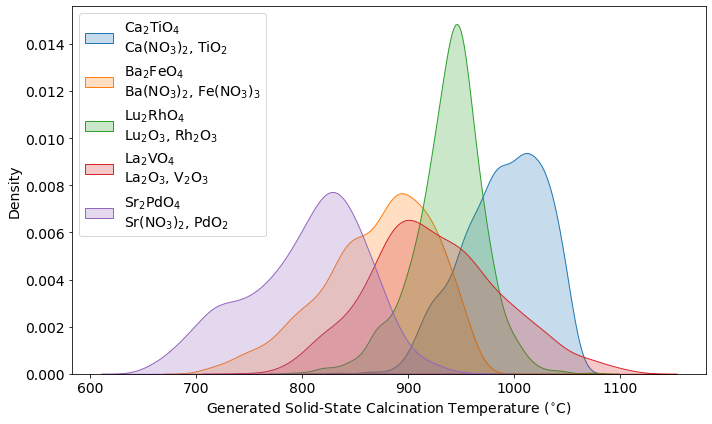

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = []
for i in range(len(query_results)):
    sns.kdeplot(query_results[i][:, 0], fill=True)
    #sns.kdeplot(result["sinter_temps"], fill=True)
    label = targets_to_plot[i] + "\n" + ", ".join(precursors_to_plot[i])
    labels.append(label)
ax.set_xlabel("Generated Solid-State Calcination Temperature $(^{\circ}$C)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

ax.legend(labels, loc="upper left", fontsize=14)
# ax.set_xlim(500, 1000)
# ax.set_yticks(np.linspace(0, 0.016, 5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
fig.savefig('figures/MIT_compounds_ss_precursor_calcine_sensitivity.png', dpi=200)

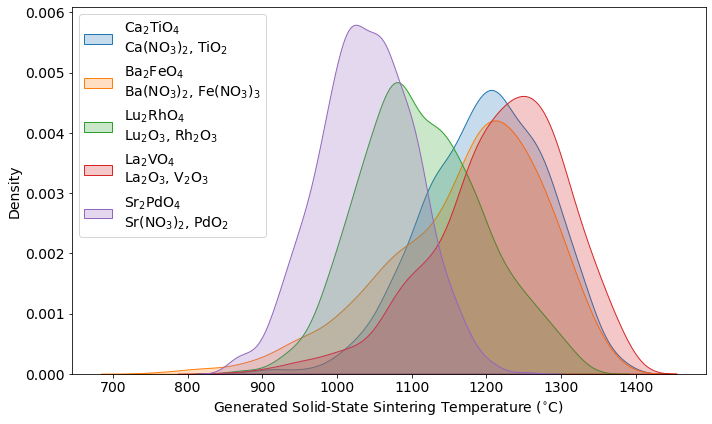

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = []
for i in range(len(query_results)):
    sns.kdeplot(query_results[i][:, 1], fill=True)
    label = targets_to_plot[i] + "\n" + ", ".join(precursors_to_plot[i])
    labels.append(label)
ax.set_xlabel("Generated Solid-State Sintering Temperature $(^{\circ}$C)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

ax.legend(labels, loc="upper left", fontsize=14)
# ax.set_xlim(500, 1000)
# ax.set_yticks(np.linspace(0, 0.016, 5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
fig.savefig('figures/MIT_compounds_ss_precursor_sinter_sensitivity.png', dpi=200)

In [11]:
def clean_formulas(formula_list):
    chem_list = [re.sub("([0-9]+(\.[0-9]+)?)", "_{\\1}", k) for k in formula_list]
    chem_list = ['$\mathregular{'+list_k+'}$' for list_k in chem_list]
    return chem_list